<a href="https://www.bigdatauniversity.com"><img src="https://ibm.box.com/shared/static/cw2c7r3o20w9zn8gkecaeyjhgw3xdgbj.png" width="400" align="center"></a>

<h1 align="center"><font size="5">Classification with Python</font></h1>

In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:

In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Lets download the dataset

In [2]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2020-07-01 16:43:43--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

100%[======================================>] 23,101      --.-K/s   in 0.07s   

2020-07-01 16:43:43 (305 KB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File  

In [3]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [4]:
df.shape

(346, 10)

### Convert to date time object 

In [5]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing



Let’s see how many of each class is in our data set 

In [6]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:

In [7]:
# notice: installing seaborn might takes a few minutes
!conda install -c anaconda seaborn -y

Solving environment: done

# All requested packages already installed.



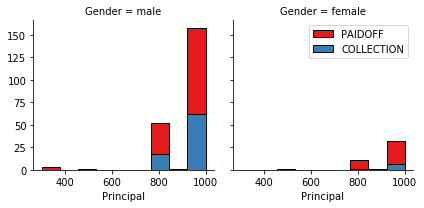

In [8]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

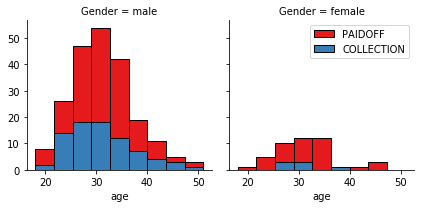

In [9]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

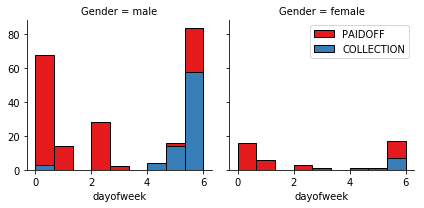

In [10]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [11]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>4)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,0
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,0


## Convert Categorical features to numerical values

Lets look at gender:

In [12]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [13]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,0
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,0


## One Hot Encoding  
#### How about education?

In [14]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Feature befor One Hot Encoding

In [15]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame 

In [16]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,0,0,0,1
4,1000,30,29,0,0,0,0,1


### Feature selection

Lets defind feature sets, X:

In [17]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,0,0,0,1
4,1000,30,29,0,0,0,0,1


What are our lables?

In [18]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [19]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:1: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  if __name__ == '__main__':


array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.14984679,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.14984679,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.14984679,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177, -1.14984679,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004, -1.14984679,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification 

Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression



__ Notice:__ 
- You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
- You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
- You should include the code of the algorithm in the following cells.

# K Nearest Neighbor(KNN)
Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the __loan_test.csv__ for finding the best k, however, you can split your train_loan.csv into train and test to find the best __k__.

In [20]:
from sklearn.model_selection import train_test_split
X_traink, X_testk, y_traink, y_testk = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_traink.shape,  y_traink.shape)
print ('Test set:', X_testk.shape,  y_testk.shape)

Train set: (276, 8) (276,)
Test set: (70, 8) (70,)


In [21]:
from sklearn.neighbors import KNeighborsClassifier
k = 4
#Train Model and Predict  
neigh = KNeighborsClassifier(n_neighbors = k).fit(X_traink,y_traink)
neigh
yhatk = neigh.predict(X_testk)
yhatk[0:5]

array(['PAIDOFF', 'COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

In [22]:
from sklearn import metrics
print("Train set Accuracy: ", metrics.accuracy_score(y_traink, neigh.predict(X_traink)))
print("Test set Accuracy: ", metrics.accuracy_score(y_testk, yhatk))

Train set Accuracy:  0.8115942028985508
Test set Accuracy:  0.6857142857142857


In [23]:
#Finding the best value of k
Ks = 15
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = [];
for n in range(1,Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_traink,y_traink)
    yhatk=neigh.predict(X_testk)
    mean_acc[n-1] = metrics.accuracy_score(y_testk, yhatk)

    
    std_acc[n-1]=np.std(yhatk==y_testk)/np.sqrt(yhatk.shape[0])

mean_acc

array([0.62857143, 0.61428571, 0.74285714, 0.68571429, 0.77142857,
       0.72857143, 0.75714286, 0.75714286, 0.7       , 0.65714286,
       0.7       , 0.71428571, 0.71428571, 0.68571429])

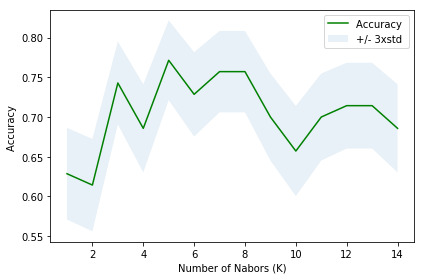

In [24]:
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Nabors (K)')
plt.tight_layout()
plt.show()

In [25]:
print( "The best accuracy was with", mean_acc.max(), "with k=", mean_acc.argmax()+1) 

The best accuracy was with 0.7714285714285715 with k= 5


In [26]:
k = 13
#Train Model and Predict  
neighf = KNeighborsClassifier(n_neighbors = k).fit(X_traink,y_traink)
neighf
yhat2k = neighf.predict(X_testk)

# Decision Tree

In [27]:
from sklearn.model_selection import train_test_split
X_trainsetd, X_testsetd, y_trainsetd, y_testsetd = train_test_split(X, y, test_size=0.3, random_state=3)

In [28]:
from sklearn.tree import DecisionTreeClassifier
decTree = DecisionTreeClassifier(criterion="entropy",max_depth=10)
decTree.fit(X_trainsetd,y_trainsetd)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [29]:
predTree = decTree.predict(X_testsetd)

In [30]:
from sklearn import metrics
import matplotlib.pyplot as plt
print("DecisionTrees's Accuracy: ", metrics.accuracy_score(y_testsetd, predTree))

DecisionTrees's Accuracy:  0.6730769230769231


In [69]:
from sklearn import decomposition, datasets
from sklearn import tree
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
# Create a pca object
pca = decomposition.PCA()

# Create a logistic regression object with an L2 penalty
decisiontree = tree.DecisionTreeClassifier()

# Create a pipeline of three steps. First, standardize the data.
# Second, tranform the data with PCA.
# Third, train a Decision Tree Classifier on the data.
pipe = Pipeline(steps=[('pca', pca),('decisiontree', decisiontree)])

# Create Parameter Space
# Create a list of a sequence of integers from 1 to 30 (the number of features in X + 1)
n_components = list(range(1,X.shape[1]+1,1))

# Create lists of parameter for Decision Tree Classifier
criterion = ['gini', 'entropy']
max_depth = [4,6,8,12]

# Create a dictionary of all the parameter options 
# Note has you can access the parameters of steps of a pipeline by using '__’
parameters = dict(pca__n_components=n_components,decisiontree__criterion=criterion,decisiontree__max_depth=max_depth)

# Conduct Parameter Optmization With Pipeline
# Create a grid search object
decTreef = GridSearchCV(pipe, parameters)

# Fit the grid search
decTreef.fit(X_trainsetd,y_trainsetd)

# View The Best Parameters
print('Best Criterion:', decTreef.best_estimator_.get_params()['decisiontree__criterion'])
print('Best max_depth:', decTreef.best_estimator_.get_params()['decisiontree__max_depth'])
print('Best Number Of Components:', decTreef.best_estimator_.get_params()['pca__n_components'])
print(); print(decTreef.best_estimator_.get_params()['decisiontree'])


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Best Criterion: gini
Best max_depth: 4
Best Number Of Components: 2

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [70]:
decTreeff = DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,max_features=None, max_leaf_nodes=None,min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
decTreeff.fit(X_trainsetd,y_trainsetd)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [71]:
print("DecisionTrees's Accuracy: ", metrics.accuracy_score(y_testsetd, decTreeff.predict(X_testsetd)))

DecisionTrees's Accuracy:  0.6538461538461539


# Support Vector Machine

In [31]:
X_trains, X_tests, y_trains, y_tests = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_trains.shape,  y_trains.shape)
print ('Test set:', X_tests.shape,  y_tests.shape)

Train set: (276, 8) (276,)
Test set: (70, 8) (70,)


In [32]:
from sklearn import svm
from sklearn.svm import SVC
clf = svm.SVC(kernel='rbf')
clf.fit(X_trains, y_trains) 

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [33]:
yhats = clf.predict(X_tests)
yhats [0:5]

array(['COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

In [34]:
from sklearn.metrics import f1_score
f1_score(y_tests, yhats, average='weighted') 

0.7173645320197043

In [35]:
from sklearn.metrics import jaccard_similarity_score
jaccard_similarity_score(y_tests, yhats)

0.7428571428571429

In [36]:
from sklearn.model_selection import GridSearchCV
param_grid = {'C': [0.01,0.1,1, 10, 100], 'gamma': [10,1,0.1,0.01],'kernel': ['rbf', 'linear', 'sigmoid']}
grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=2)


In [37]:
grid.fit(X_trains,y_trains)

Fitting 3 folds for each of 60 candidates, totalling 180 fits
[CV] C=0.01, gamma=10, kernel=rbf ....................................
[CV] ..................... C=0.01, gamma=10, kernel=rbf, total=   0.0s
[CV] C=0.01, gamma=10, kernel=rbf ....................................
[CV] ..................... C=0.01, gamma=10, kernel=rbf, total=   0.0s
[CV] C=0.01, gamma=10, kernel=rbf ....................................
[CV] ..................... C=0.01, gamma=10, kernel=rbf, total=   0.0s
[CV] C=0.01, gamma=10, kernel=linear .................................
[CV] .................. C=0.01, gamma=10, kernel=linear, total=   0.0s
[CV] C=0.01, gamma=10, kernel=linear .................................
[CV] .................. C=0.01, gamma=10, kernel=linear, total=   0.0s
[CV] C=0.01, gamma=10, kernel=linear .................................
[CV] .................. C=0.01, gamma=10, kernel=linear, total=   0.0s
[CV] C=0.01, gamma=10, kernel=sigmoid ................................
[CV] ..........

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ................ C=0.01, gamma=0.01, kernel=linear, total=   0.0s
[CV] C=0.01, gamma=0.01, kernel=linear ...............................
[CV] ................ C=0.01, gamma=0.01, kernel=linear, total=   0.0s
[CV] C=0.01, gamma=0.01, kernel=sigmoid ..............................
[CV] ............... C=0.01, gamma=0.01, kernel=sigmoid, total=   0.0s
[CV] C=0.01, gamma=0.01, kernel=sigmoid ..............................
[CV] ............... C=0.01, gamma=0.01, kernel=sigmoid, total=   0.0s
[CV] C=0.01, gamma=0.01, kernel=sigmoid ..............................
[CV] ............... C=0.01, gamma=0.01, kernel=sigmoid, total=   0.0s
[CV] C=0.1, gamma=10, kernel=rbf .....................................
[CV] ...................... C=0.1, gamma=10, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=10, kernel=rbf .....................................
[CV] ...................... C=0.1, gamma=10, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=10, kernel=rbf .....................................
[CV] .

[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:    0.9s finished
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [0.01, 0.1, 1, 10, 100], 'gamma': [10, 1, 0.1, 0.01], 'kernel': ['rbf', 'linear', 'sigmoid']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

In [38]:
print(grid.best_estimator_)

SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1, kernel='sigmoid',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [39]:
print("Avg F1-score: %.4f" % f1_score(y_tests,grid.predict(X_tests), average='weighted'))
print("Jaccard score: %.4f" % jaccard_similarity_score(y_tests,grid.predict(X_tests)))

Avg F1-score: 0.6973
Jaccard score: 0.7143


In [40]:
clf2 = svm.SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1, kernel='sigmoid',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
clf2.fit(X_trains, y_trains) 
yhat2s = clf2.predict(X_tests)
print("Avg F1-score: %.4f" % f1_score(y_tests, yhat2s, average='weighted'))
print("Jaccard score: %.4f" % jaccard_similarity_score(y_tests, yhat2s))

Avg F1-score: 0.6973
Jaccard score: 0.7143


In [41]:
#clf3 = svm.SVC(kernel='poly')
#clf3.fit(X_trains, y_trains) 
#yhat3s = clf3.predict(X_tests)
#print("Avg F1-score: %.4f" % f1_score(y_tests, yhat3s, average='weighted'))
#print("Jaccard score: %.4f" % jaccard_similarity_score(y_tests, yhat3s))

# Logistic Regression

In [42]:
X_trainl, X_testl, y_trainl, y_testl = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_trainl.shape,  y_trainl.shape)
print ('Test set:', X_testl.shape,  y_testl.shape)

Train set: (276, 8) (276,)
Test set: (70, 8) (70,)


In [43]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
LR = LogisticRegression(C=0.1, solver='liblinear').fit(X_trainl,y_trainl)
yhatl = LR.predict(X_testl)
yhatl

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'COLLECTION',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'COLLECTION', 'PAIDOFF', 'PAIDOFF', 'COLLECTION', 'COLLECTION',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'COLLECTION', 'PAIDOFF', 'PAIDOFF', 'COLLECTION',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF'], dtype=object)

In [44]:
yhat_prob = LR.predict_proba(X_testl)
yhat_prob

array([[0.49764135, 0.50235865],
       [0.4030356 , 0.5969644 ],
       [0.11727277, 0.88272723],
       [0.16310134, 0.83689866],
       [0.12757055, 0.87242945],
       [0.12970143, 0.87029857],
       [0.45467396, 0.54532604],
       [0.42636056, 0.57363944],
       [0.16310134, 0.83689866],
       [0.47576977, 0.52423023],
       [0.15540962, 0.84459038],
       [0.4735713 , 0.5264287 ],
       [0.08300149, 0.91699851],
       [0.16449766, 0.83550234],
       [0.32765274, 0.67234726],
       [0.06980411, 0.93019589],
       [0.5548756 , 0.4451244 ],
       [0.11044887, 0.88955113],
       [0.14801647, 0.85198353],
       [0.12870947, 0.87129053],
       [0.33452475, 0.66547525],
       [0.46641527, 0.53358473],
       [0.52634501, 0.47365499],
       [0.41754517, 0.58245483],
       [0.28537577, 0.71462423],
       [0.51200308, 0.48799692],
       [0.519178  , 0.480822  ],
       [0.22237206, 0.77762794],
       [0.49509288, 0.50490712],
       [0.05824681, 0.94175319],
       [0.

In [45]:
from sklearn.metrics import log_loss
print("Avg F1-score: %.4f" % f1_score(y_testl, yhatl, average='weighted'))
print("Jaccard score: %.4f" % jaccard_similarity_score(y_testl, yhatl))
print ("LogLoss: : %.2f" % log_loss(y_testl, yhat_prob))

Avg F1-score: 0.7048
Jaccard score: 0.7429
LogLoss: : 0.50


In [46]:
grid={"C":np.logspace(-3,3,7), "solver":["liblinear","sag","newton-cg","lbfgs"]}
LRf=GridSearchCV(LogisticRegression(),grid,cv=10)

In [47]:
LRf.fit(X_trainl,y_trainl)
print("tuned hpyerparameters :(best parameters) ",LRf.best_params_)
print("Avg F1-score: %.4f" % f1_score(y_testl, LRf.predict(X_testl), average='weighted'))
print("Jaccard score: %.4f" % jaccard_similarity_score(y_testl, LRf.predict(X_testl)))
print ("LogLoss: : %.2f" % log_loss(y_testl, LRf.predict_proba(X_testl)))

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The ma

tuned hpyerparameters :(best parameters)  {'C': 0.1, 'solver': 'liblinear'}
Avg F1-score: 0.7048
Jaccard score: 0.7429
LogLoss: : 0.50


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [48]:
LR2 = LogisticRegression(C=0.01, solver='sag').fit(X_trainl,y_trainl)
yhat_prob2 = LR2.predict_proba(X_testl)
print ("LogLoss: : %.2f" % log_loss(y_testl, yhat_prob2))

LogLoss: : 0.49


In [49]:
LR3 = LogisticRegression(C=0.01, solver='newton-cg').fit(X_trainl,y_trainl)
yhat_prob3 = LR3.predict_proba(X_testl)
print ("LogLoss: : %.2f" % log_loss(y_testl, yhat_prob3))

LogLoss: : 0.49


In [50]:
LR4 = LogisticRegression(C=0.01, solver='lbfgs').fit(X_trainl,y_trainl)
yhat_prob4 = LR4.predict_proba(X_testl)
print ("LogLoss: : %.2f" % log_loss(y_testl, yhat_prob4))

LogLoss: : 0.49


# Model Evaluation using Test set

In [51]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

First, download and load the test set:

In [52]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2020-07-01 16:46:12--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

100%[======================================>] 3,642       --.-K/s   in 0s      

2020-07-01 16:46:12 (390 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation 

In [53]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [54]:
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,Bechalor,female
1,5,5,PAIDOFF,300,7,2016-09-09,2016-09-15,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,2016-09-10,2016-10-09,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,2016-09-10,2016-10-09,26,college,male
4,35,35,PAIDOFF,800,15,2016-09-11,2016-09-25,29,Bechalor,male


In [55]:
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>4)  else 0)
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,1,1,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,Bechalor,female,3,0
1,5,5,PAIDOFF,300,7,2016-09-09,2016-09-15,35,Master or Above,male,4,0
2,21,21,PAIDOFF,1000,30,2016-09-10,2016-10-09,43,High School or Below,female,5,1
3,24,24,PAIDOFF,1000,30,2016-09-10,2016-10-09,26,college,male,5,1
4,35,35,PAIDOFF,800,15,2016-09-11,2016-09-25,29,Bechalor,male,6,1


In [56]:
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,1,1,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,Bechalor,1,3,0
1,5,5,PAIDOFF,300,7,2016-09-09,2016-09-15,35,Master or Above,0,4,0
2,21,21,PAIDOFF,1000,30,2016-09-10,2016-10-09,43,High School or Below,1,5,1
3,24,24,PAIDOFF,1000,30,2016-09-10,2016-10-09,26,college,0,5,1
4,35,35,PAIDOFF,800,15,2016-09-11,2016-09-25,29,Bechalor,0,6,1


In [57]:
Feature = test_df[['Principal','age','Gender','terms','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(test_df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,age,Gender,terms,weekend,Bechalor,High School or Below,college
0,1000,50,1,30,0,1,0,0
1,300,35,0,7,0,0,0,0
2,1000,43,1,30,1,0,1,0
3,1000,26,0,30,1,0,0,1
4,800,29,0,15,1,1,0,0


In [58]:
X_t = Feature
X_t[0:5]

,Principal,age,Gender,terms,weekend,Bechalor,High School or Below,college
0,1000,50,1,30,0,1,0,0
1,300,35,0,7,0,0,0,0
2,1000,43,1,30,1,0,1,0
3,1000,26,0,30,1,0,0,1
4,800,29,0,15,1,1,0,0


In [59]:
y_t = test_df['loan_status'].values
y_t[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

In [60]:
X_t= preprocessing.StandardScaler().fit(X_t).transform(X_t)
X_t[0:5]

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:1: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  if __name__ == '__main__':


array([[ 0.49362588,  3.05981865,  1.97714211,  0.92844966, -1.20604538,
         2.39791576, -0.79772404, -0.86135677],
       [-3.56269116,  0.53336288, -0.50578054, -1.70427745, -1.20604538,
        -0.41702883, -0.79772404, -0.86135677],
       [ 0.49362588,  1.88080596,  1.97714211,  0.92844966,  0.8291562 ,
        -0.41702883,  1.25356634, -0.86135677],
       [ 0.49362588, -0.98251057, -0.50578054,  0.92844966,  0.8291562 ,
        -0.41702883, -0.79772404,  1.16095912],
       [-0.66532184, -0.47721942, -0.50578054, -0.78854628,  0.8291562 ,
         2.39791576, -0.79772404, -0.86135677]])

In [61]:
knnf=f1_score(y_t,neighf.predict(X_t), average='weighted')
knnj=jaccard_similarity_score(y_t,neighf.predict(X_t))

In [98]:
dtf=f1_score(y_t, decTreeff.predict(X_t), average='weighted')
dtj=jaccard_similarity_score(y_t, decTreeff.predict(X_t))

In [99]:
svmf=f1_score(y_t, clf.predict(X_t), average='weighted')
svmj=jaccard_similarity_score(y_t, clf.predict(X_t))

In [100]:
lrf=f1_score(y_t, LR2.predict(X_t), average='weighted',labels=np.unique(LR2.predict(X_t)))
lrj=jaccard_similarity_score(y_t, LR2.predict(X_t))

In [101]:
lrll=log_loss(y_t, LR2.predict_proba(X_t))

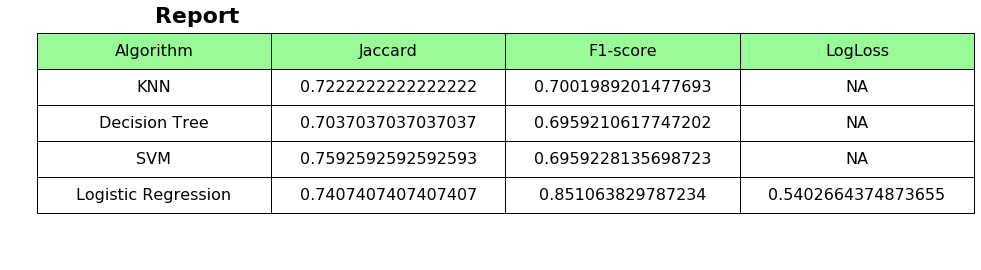

In [102]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
import matplotlib
data=[["KNN",knnj,knnf,"NA"],
     ["Decision Tree",dtj,dtf,"NA"],
     ["SVM",svmj,svmf,"NA"],
     ["Logistic Regression",lrj,lrf,lrll]]
columns=("Algorithm","Jaccard","F1-score","LogLoss")
fig, ax = plt.subplots() 
ax.set_axis_off()
table = ax.table(cellText = data,colWidths=[0.7 for x in columns],colLabels = columns,colColours =["palegreen"] * 10,cellLoc ='center',loc ='upper left')
table.set_fontsize(16)
table.scale(1,3)
ax.set_title('Report', 
             fontweight ="bold", fontsize=22) 
  
plt.show() 

# Report
You should be able to report the accuracy of the built model using different evaluation metrics:

| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | ?       | ?        | NA      |
| Decision Tree      | ?       | ?        | NA      |
| SVM                | ?       | ?        | NA      |
| LogisticRegression | ?       | ?        | ?       |

<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

<p>Copyright &copy; 2018 <a href="https://cocl.us/DX0108EN_CC">Cognitive Class</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>.</p>